In [796]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from helper_functions import xy_rnn_split
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


## Setup Device Agnostic Code

In [797]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Reading the data

In [798]:
df = pd.read_excel("data\Monetary Data.xlsx")
df.head()


,Tahun,USD,JPY,DEM,NLG,GBP,FRH,CHF,SGD,MYR,HKD,AUD,CAD
0,2025,0,0,0,0,0,0,0,0,0,0,0,0
1,Januari,"16,259.00","10,523.63",0,0,"20,245.72",0,"17,938.99","12,045.96","3,701.14","2,086.94","10,117.19","11,276.50"
2,2024,0,0,0,0,0,0,0,0,0,0,0,0
3,Desember,"16,162.00","10,236.25",0,0,"20,332.61",0,"17,920.95","11,919.34","3,616.48","2,082.02","10,081.88","11,225.18"
4,November,"15,864.00","10,453.01",0,0,"20,067.98",0,"17,944.72","11,805.79","3,566.56","2,038.59","10,283.06","11,310.03"


In [799]:
months = ["Januari", "Februari", "Maret", "April", "Mei", "Juni", "Juli", "Agustus",
          "September", "Oktober", "November", "Desember"]

dates = []
current_year = None
for index, row in df.iterrows():
    if str(row["Tahun"]).isdigit():
        current_year = int(row["Tahun"])
    elif row["Tahun"] in months and current_year:
        month_num = months.index(row["Tahun"]) + 1
        dates.append(f"{current_year}-{month_num:02d}")
    else:
        dates.append(None)

In [800]:
df = df[df["Tahun"].isin(months)].reset_index(drop=True)
df["Date"] = dates
df.drop(columns=["Tahun"], inplace=True)
for col in df.columns[:-1]:
    df[col] = df[col].astype(str).str.replace(",", "").astype(float)
df = df[["Date"] + [col for col in df.columns if col != "Date"]]
df.head()

,Date,USD,JPY,DEM,NLG,GBP,FRH,CHF,SGD,MYR,HKD,AUD,CAD
0,2025-01,16259.0,10523.63,0.0,0.0,20245.72,0.0,17938.99,12045.96,3701.14,2086.94,10117.19,11276.50
1,2024-12,16162.0,10236.25,0.0,0.0,20332.61,0.0,17920.95,11919.34,3616.48,2082.02,10081.88,11225.18
2,2024-11,15864.0,10453.01,0.0,0.0,20067.98,0.0,17944.72,11805.79,3566.56,2038.59,10283.06,11310.03
3,2024-10,15732.0,10259.89,0.0,0.0,20464.98,0.0,18136.98,11878.14,3587.29,2024.54,10319.41,11302.94
4,2024-09,15138.0,10566.44,0.0,0.0,20237.24,0.0,17899.98,11788.35,3675.19,1946.10,10417.22,11222.07


In [801]:
df= df[["Date", "HKD"]]
df = df[(df["Date"] >= "2000-01")&(df["Date"] <= "2023-12")]

In [802]:
df.head(), df.tail()

(       Date      HKD
 13  2023-12  1972.71
 14  2023-11  1972.70
 15  2023-10  2034.91
 16  2023-09  1985.00
 17  2023-08  1942.00,
         Date      HKD
 284  2001-05  1417.82
 285  2001-04  1496.93
 286  2001-03  1333.49
 287  2001-02  1260.97
 288  2001-01  1211.66)

In [803]:
train = df[(df["Date"] >= "2000-01")&(df["Date"] <= "2022-12")]
test = df[(df["Date"] >= "2023-01")&(df["Date"] <= "2023-12")]

train.set_index("Date", inplace=True)
test.set_index("Date", inplace=True)

In [804]:
test.head(24)

,HKD
Date,
2023-12,1972.71
2023-11,1972.70
2023-10,2034.91
2023-09,1985.00
2023-08,1942.00
2023-07,1934.00
2023-06,1919.00
2023-05,1911.00
2023-04,1879.00


In [805]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 264 entries, 2022-12 to 2001-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HKD     264 non-null    float64
dtypes: float64(1)
memory usage: 4.1+ KB


In [806]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, 2023-12 to 2023-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HKD     12 non-null     float64
dtypes: float64(1)
memory usage: 192.0+ bytes


In [807]:
train.describe()

,HKD
count,264.000000
mean,1449.827879
std,311.273981
min,1062.000000
25%,1175.750000
50%,1318.500000
75%,1751.257500
max,3037.980000


Skewness of HKD (scipy): 0.7777990915486145


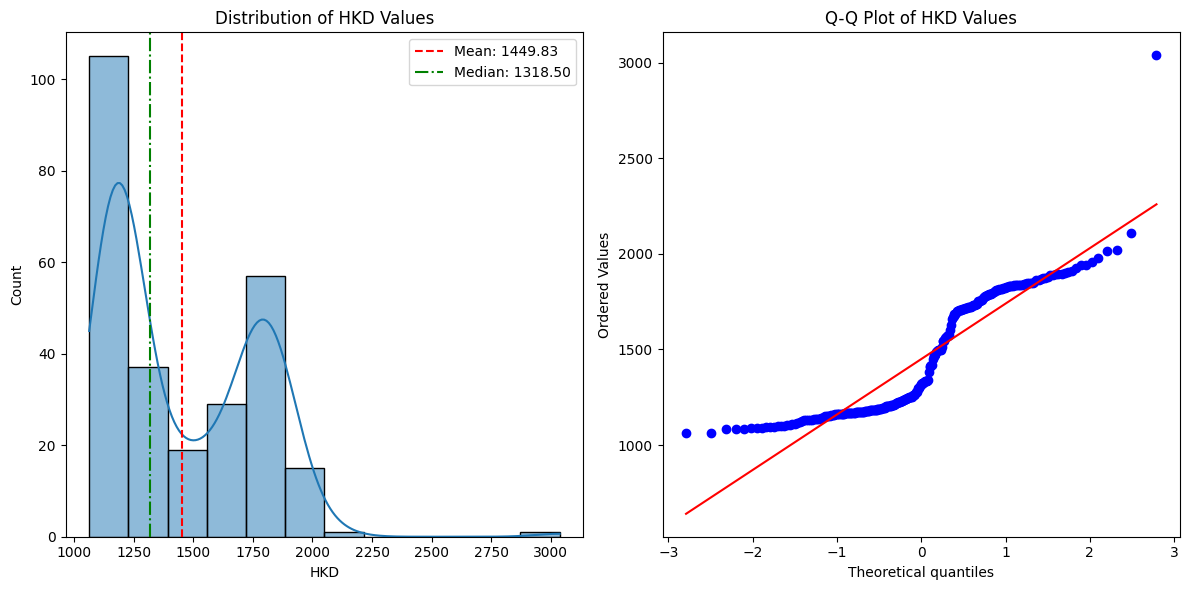

In [808]:
skewness_scipy = stats.skew(train['HKD'])
print(f"Skewness of HKD (scipy): {skewness_scipy}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(train['HKD'], kde=True)
plt.title('Distribution of HKD Values')
plt.axvline(train['HKD'].mean(), color='r', linestyle='--', label=f'Mean: {train["HKD"].mean():.2f}')
plt.axvline(train['HKD'].median(), color='g', linestyle='-.', label=f'Median: {train["HKD"].median():.2f}')
plt.legend()

plt.subplot(1, 2, 2)
stats.probplot(train['HKD'], plot=plt)
plt.title('Q-Q Plot of HKD Values')

plt.tight_layout()
plt.show()

## Data Preprocessing

Sebelum melakukan memasukkan data ke dalam model, kita harus mempreproses datanya terlebih dahulu, berikut adalah langkah-langkah yang saya ambil:
1. Melakukan `Log Transformation` pada fitur `HKD`. Dilakukan untuk mengurus Skewness pada data.
2. Melakukan `Scaling` pada fitur `HKD`. Hal ini dilakukan untuk menyamakan skala dan membuat model belajar lebih baik.
3. Melakukan `Encoding` pada fitur `Bulan`. Hal ini dilakukan untuk mengubah format data yang awalnya categorical menjadi numeric agar model dapat memprosesnya lebih baik.

**NOTE**: Tidak perlu memeriksa missing values, karena ini adalah data yang sudah di olah sebelumnya

In [809]:
train_preprocessed = train.copy()
test_preprocessed = test.copy()

Original skewness of HKD: 0.7778
Skewness after log transformation: 0.4004


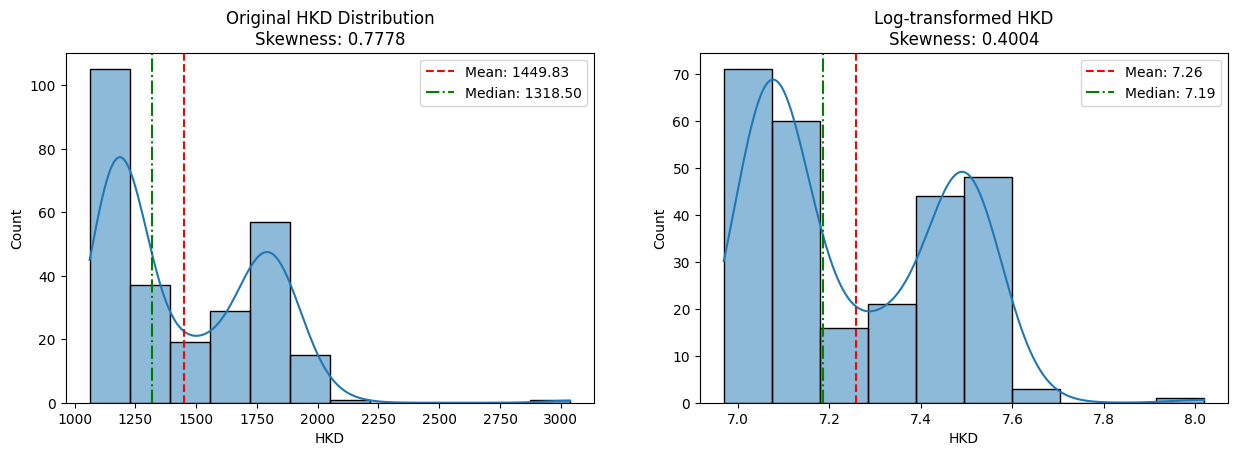

In [810]:
train_preprocessed['HKD'] = np.log1p(train['HKD'])
test_preprocessed['HKD'] = np.log1p(test['HKD'])

print(f"Original skewness of HKD: {skewness_scipy:.4f}")

log_skewness = stats.skew(train_preprocessed['HKD'])
print(f"Skewness after log transformation: {log_skewness:.4f}")

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.histplot(train['HKD'], kde=True)
plt.title(f'Original HKD Distribution\nSkewness: {skewness_scipy:.4f}')
plt.axvline(train['HKD'].mean(), color='r', linestyle='--', label=f'Mean: {train["HKD"].mean():.2f}')
plt.axvline(train['HKD'].median(), color='g', linestyle='-.', label=f'Median: {train["HKD"].median():.2f}')
plt.legend()

plt.subplot(2, 2, 2)
sns.histplot(train_preprocessed['HKD'], kde=True)
plt.title(f'Log-transformed HKD\nSkewness: {log_skewness:.4f}')
plt.axvline(train_preprocessed['HKD'].mean(), color='r', linestyle='--', label=f'Mean: {train_preprocessed["HKD"].mean():.2f}')
plt.axvline(train_preprocessed['HKD'].median(), color='g', linestyle='-.', label=f'Median: {train_preprocessed["HKD"].median():.2f}')
plt.legend()


In [811]:
scaler_target = StandardScaler()
scale_target = 'HKD'

train_preprocessed[scale_target] = scaler_target.fit_transform(train_preprocessed[[scale_target]])
test_preprocessed[scale_target] = scaler_target.transform(test_preprocessed[[scale_target]])

print(train_preprocessed.head())
print(test_preprocessed.head())

              HKD
Date             
2022-12  1.712697
2022-11  1.701553
2022-10  1.618655
2022-09  1.524706
2022-08  1.406012
              HKD
Date             
2023-12  1.600114
2023-11  1.600089
2023-10  1.750797
2023-09  1.630260
2023-08  1.523956


In [812]:
SEQUENCE_LENGTH = 3

X_train, y_train = xy_rnn_split(train_preprocessed, target_col="HKD", time_steps=SEQUENCE_LENGTH)
X_val, y_val = xy_rnn_split(test_preprocessed, target_col="HKD", time_steps=SEQUENCE_LENGTH)

In [813]:
test_preprocessed.shape, train_preprocessed.shape

((12, 1), (264, 1))

In [814]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
    
X_train = torch.Tensor(X_train)
X_val = torch.Tensor(X_val)
y_train = torch.Tensor(y_train)
y_val = torch.Tensor(y_val)

X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

(torch.Size([261, 3, 1]),
 torch.Size([261, 1]),
 torch.Size([9, 3, 1]),
 torch.Size([9, 1]))

## Modeling RNN

In [815]:
# Define the RNN model
class MonetaryRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MonetaryRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden=None):
        if hidden is None:
            hidden = torch.zeros(1, x.size(0), self.hidden_size, device=x.device)
        
        output, hidden = self.rnn(x, hidden)
        
        output = self.fc(output[:, -1, :])
        return output, hidden

In [816]:
INPUT_SIZE = X_train.shape[2]
HIDDEN_SIZE = 128
OUTPUT_SIZE = 1

model_0 = MonetaryRNN(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
model_0 = model_0.to(device)

model_0

MonetaryRNN(
  (rnn): RNN(1, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [817]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model_0.parameters(), lr=0.001)

 12%|█▏        | 6/50 [00:00<00:01, 27.12it/s]

Epoch [1/50], Train Loss: 0.9081, Val Loss: 0.7363, RMSE: 0.8581, MAE: 0.8558, R²: -150.1838
Epoch [2/50], Train Loss: 0.2776, Val Loss: 0.0614, RMSE: 0.2478, MAE: 0.2355, R²: -11.6089
Epoch [3/50], Train Loss: 0.1285, Val Loss: 0.0329, RMSE: 0.1813, MAE: 0.1596, R²: -5.7509
Epoch [4/50], Train Loss: 0.0937, Val Loss: 0.0318, RMSE: 0.1784, MAE: 0.1616, R²: -5.5341
Epoch [5/50], Train Loss: 0.0944, Val Loss: 0.0575, RMSE: 0.2398, MAE: 0.2282, R²: -10.8027
Epoch [6/50], Train Loss: 0.0920, Val Loss: 0.0125, RMSE: 0.1117, MAE: 0.0820, R²: -1.5606


 18%|█▊        | 9/50 [00:00<00:01, 28.04it/s]

Epoch [7/50], Train Loss: 0.0841, Val Loss: 0.0133, RMSE: 0.1151, MAE: 0.0858, R²: -1.7219
Epoch [8/50], Train Loss: 0.0826, Val Loss: 0.0266, RMSE: 0.1630, MAE: 0.1450, R²: -4.4544
Epoch [9/50], Train Loss: 0.0841, Val Loss: 0.0167, RMSE: 0.1294, MAE: 0.1052, R²: -2.4361
Epoch [10/50], Train Loss: 0.0817, Val Loss: 0.0164, RMSE: 0.1279, MAE: 0.1038, R²: -2.3609
Epoch [11/50], Train Loss: 0.0810, Val Loss: 0.0194, RMSE: 0.1393, MAE: 0.1180, R²: -2.9822


 32%|███▏      | 16/50 [00:00<00:01, 26.84it/s]

Epoch [12/50], Train Loss: 0.0810, Val Loss: 0.0158, RMSE: 0.1257, MAE: 0.1015, R²: -2.2424
Epoch [13/50], Train Loss: 0.0798, Val Loss: 0.0172, RMSE: 0.1312, MAE: 0.1087, R²: -2.5327
Epoch [14/50], Train Loss: 0.0796, Val Loss: 0.0160, RMSE: 0.1263, MAE: 0.1029, R²: -2.2774
Epoch [15/50], Train Loss: 0.0790, Val Loss: 0.0159, RMSE: 0.1260, MAE: 0.1026, R²: -2.2577
Epoch [16/50], Train Loss: 0.0786, Val Loss: 0.0154, RMSE: 0.1243, MAE: 0.1007, R²: -2.1700
Epoch [17/50], Train Loss: 0.0782, Val Loss: 0.0150, RMSE: 0.1226, MAE: 0.0995, R²: -2.0881
Epoch [18/50], Train Loss: 0.0779, Val Loss: 0.0148, RMSE: 0.1215, MAE: 0.0988, R²: -2.0319


 46%|████▌     | 23/50 [00:00<00:00, 28.26it/s]

Epoch [19/50], Train Loss: 0.0776, Val Loss: 0.0144, RMSE: 0.1198, MAE: 0.0975, R²: -1.9484
Epoch [20/50], Train Loss: 0.0773, Val Loss: 0.0141, RMSE: 0.1188, MAE: 0.0969, R²: -1.8991
Epoch [21/50], Train Loss: 0.0770, Val Loss: 0.0138, RMSE: 0.1173, MAE: 0.0957, R²: -1.8261
Epoch [22/50], Train Loss: 0.0768, Val Loss: 0.0135, RMSE: 0.1162, MAE: 0.0948, R²: -1.7727
Epoch [23/50], Train Loss: 0.0765, Val Loss: 0.0133, RMSE: 0.1152, MAE: 0.0940, R²: -1.7248
Epoch [24/50], Train Loss: 0.0762, Val Loss: 0.0129, RMSE: 0.1134, MAE: 0.0924, R²: -1.6415
Epoch [25/50], Train Loss: 0.0759, Val Loss: 0.0129, RMSE: 0.1138, MAE: 0.0929, R²: -1.6589


 62%|██████▏   | 31/50 [00:01<00:00, 29.93it/s]

Epoch [26/50], Train Loss: 0.0758, Val Loss: 0.0121, RMSE: 0.1099, MAE: 0.0892, R²: -1.4818
Epoch [27/50], Train Loss: 0.0753, Val Loss: 0.0129, RMSE: 0.1138, MAE: 0.0931, R²: -1.6573
Epoch [28/50], Train Loss: 0.0753, Val Loss: 0.0110, RMSE: 0.1051, MAE: 0.0843, R²: -1.2672
Epoch [29/50], Train Loss: 0.0746, Val Loss: 0.0134, RMSE: 0.1156, MAE: 0.0950, R²: -1.7442
Epoch [30/50], Train Loss: 0.0750, Val Loss: 0.0099, RMSE: 0.0993, MAE: 0.0782, R²: -1.0238
Epoch [31/50], Train Loss: 0.0738, Val Loss: 0.0137, RMSE: 0.1169, MAE: 0.0964, R²: -1.8072
Epoch [32/50], Train Loss: 0.0748, Val Loss: 0.0097, RMSE: 0.0983, MAE: 0.0774, R²: -0.9845


 78%|███████▊  | 39/50 [00:01<00:00, 30.60it/s]

Epoch [33/50], Train Loss: 0.0737, Val Loss: 0.0110, RMSE: 0.1048, MAE: 0.0841, R²: -1.2541
Epoch [34/50], Train Loss: 0.0743, Val Loss: 0.0157, RMSE: 0.1254, MAE: 0.1056, R²: -2.2268
Epoch [35/50], Train Loss: 0.0755, Val Loss: 0.0049, RMSE: 0.0700, MAE: 0.0515, R²: -0.0061
Epoch [36/50], Train Loss: 0.0715, Val Loss: 0.0574, RMSE: 0.2396, MAE: 0.2305, R²: -10.7841
Epoch [37/50], Train Loss: 0.0838, Val Loss: 0.0364, RMSE: 0.1908, MAE: 0.1770, R²: -6.4767
Epoch [38/50], Train Loss: 0.0770, Val Loss: 0.1842, RMSE: 0.4292, MAE: 0.4246, R²: -36.8180
Epoch [39/50], Train Loss: 0.1291, Val Loss: 0.0606, RMSE: 0.2462, MAE: 0.2366, R²: -11.4490


 86%|████████▌ | 43/50 [00:01<00:00, 31.13it/s]

Epoch [40/50], Train Loss: 0.1359, Val Loss: 0.1259, RMSE: 0.3549, MAE: 0.3502, R²: -24.8567
Epoch [41/50], Train Loss: 0.1232, Val Loss: 0.0043, RMSE: 0.0654, MAE: 0.0507, R²: 0.1230
Epoch [42/50], Train Loss: 0.0740, Val Loss: 0.0247, RMSE: 0.1573, MAE: 0.1462, R²: -4.0788
Epoch [43/50], Train Loss: 0.0731, Val Loss: 0.0039, RMSE: 0.0628, MAE: 0.0475, R²: 0.1899
Epoch [44/50], Train Loss: 0.0695, Val Loss: 0.0225, RMSE: 0.1499, MAE: 0.1372, R²: -3.6147
Epoch [45/50], Train Loss: 0.0722, Val Loss: 0.0090, RMSE: 0.0947, MAE: 0.0722, R²: -0.8427
Epoch [46/50], Train Loss: 0.0693, Val Loss: 0.0066, RMSE: 0.0815, MAE: 0.0607, R²: -0.3632


100%|██████████| 50/50 [00:01<00:00, 29.56it/s]

Epoch [47/50], Train Loss: 0.0686, Val Loss: 0.0128, RMSE: 0.1133, MAE: 0.0951, R²: -1.6361
Epoch [48/50], Train Loss: 0.0702, Val Loss: 0.0080, RMSE: 0.0897, MAE: 0.0676, R²: -0.6521
Epoch [49/50], Train Loss: 0.0691, Val Loss: 0.0100, RMSE: 0.1000, MAE: 0.0782, R²: -1.0523
Epoch [50/50], Train Loss: 0.0697, Val Loss: 0.0084, RMSE: 0.0917, MAE: 0.0697, R²: -0.7248


Text(0.5, 1.0, 'Training and Validation Loss')

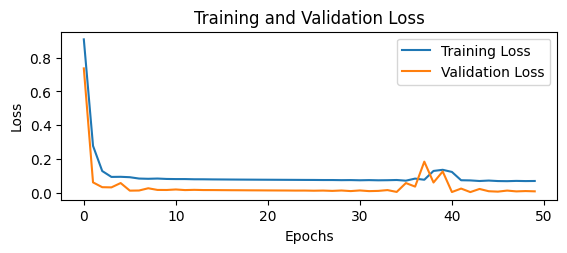

In [818]:
EPOCHS = 50
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in tqdm(range(EPOCHS)):
    model_0.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        outputs, _ = model_0(X_batch)
        loss = criterion(outputs, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
    
    train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    model_0.eval()
    val_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs, _ = model_0(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())
    
    val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}], "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"RMSE: {rmse:.4f}, "
          f"MAE: {mae:.4f}, "
          f"R²: {r2:.4f}")

plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

Text(0.5, 1.0, 'Predictions vs Actual (Original Scale)')

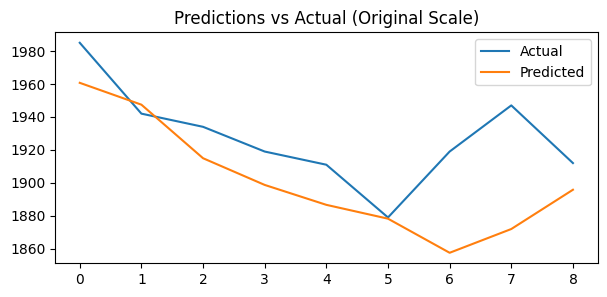

In [819]:
eval_predictions = scaler_target.inverse_transform(all_preds)
eval_actual = scaler_target.inverse_transform(all_targets.reshape(-1, 1))

eval_predictions = np.expm1(eval_predictions)
eval_actual = np.expm1(eval_actual)

plt.figure(figsize=(7, 3))
plt.plot(eval_actual, label='Actual')
plt.plot(eval_predictions, label='Predicted')
plt.legend()
plt.title('Predictions vs Actual (Original Scale)')

In [820]:
# MSE
mse = mean_squared_error(eval_actual, eval_predictions)
print(f"Mean Squared Error: {mse:.2f}")
# RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse:.2f}")
# MAE
mae = mean_absolute_error(eval_actual, eval_predictions)
print(f"Mean Absolute Error: {mae:.2f}")
# MAPE
mape = np.mean(np.abs((eval_actual - eval_predictions) / eval_actual)) * 100
print(f"Mean Absolute Percentage Error: {mape:.2f}%")

Mean Squared Error: 1294.26
Root Mean Squared Error: 35.98
Mean Absolute Error: 27.42
Mean Absolute Percentage Error: 1.42%


In [830]:
class MonetaryLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(MonetaryLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.rnn = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size//2, output_size)
        )
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.rnn(x, (h0, c0))
        
        out = out[:, -1, :]
        
        out = self.fc(out)
        return out

In [831]:
INPUT_SIZE = X_train.shape[2]
HIDDEN_SIZE = 128
NUM_LAYERS = 2
OUTPUT_SIZE = 1
DROPOUT = 0.2

model_1 = MonetaryLSTM(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, DROPOUT)
model_1 = model_1.to(device)

model_1

MonetaryLSTM(
  (rnn): LSTM(1, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [832]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)

d:\File\Anaconda\envs\PT\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


 12%|█▏        | 6/50 [00:00<00:03, 14.32it/s]

Epoch [5/50], Train Loss: 0.317541, Val Loss: 0.192084


 24%|██▍       | 12/50 [00:00<00:02, 15.94it/s]

Epoch [10/50], Train Loss: 0.129633, Val Loss: 0.038397


 36%|███▌      | 18/50 [00:01<00:01, 16.72it/s]

Epoch [15/50], Train Loss: 0.122622, Val Loss: 0.020190


 44%|████▍     | 22/50 [00:01<00:01, 16.97it/s]

Epoch [20/50], Train Loss: 0.114108, Val Loss: 0.013362


 56%|█████▌    | 28/50 [00:01<00:01, 17.19it/s]

Epoch [25/50], Train Loss: 0.099960, Val Loss: 0.049094


 64%|██████▍   | 32/50 [00:01<00:01, 17.18it/s]

Epoch [30/50], Train Loss: 0.103370, Val Loss: 0.077031


 76%|███████▌  | 38/50 [00:02<00:00, 17.30it/s]

Epoch [35/50], Train Loss: 0.093638, Val Loss: 0.012428


 84%|████████▍ | 42/50 [00:02<00:00, 17.47it/s]

Epoch [40/50], Train Loss: 0.128840, Val Loss: 0.091125


 96%|█████████▌| 48/50 [00:02<00:00, 16.73it/s]

Epoch [45/50], Train Loss: 0.088808, Val Loss: 0.015976


100%|██████████| 50/50 [00:03<00:00, 16.54it/s]


Epoch [50/50], Train Loss: 0.088605, Val Loss: 0.005209


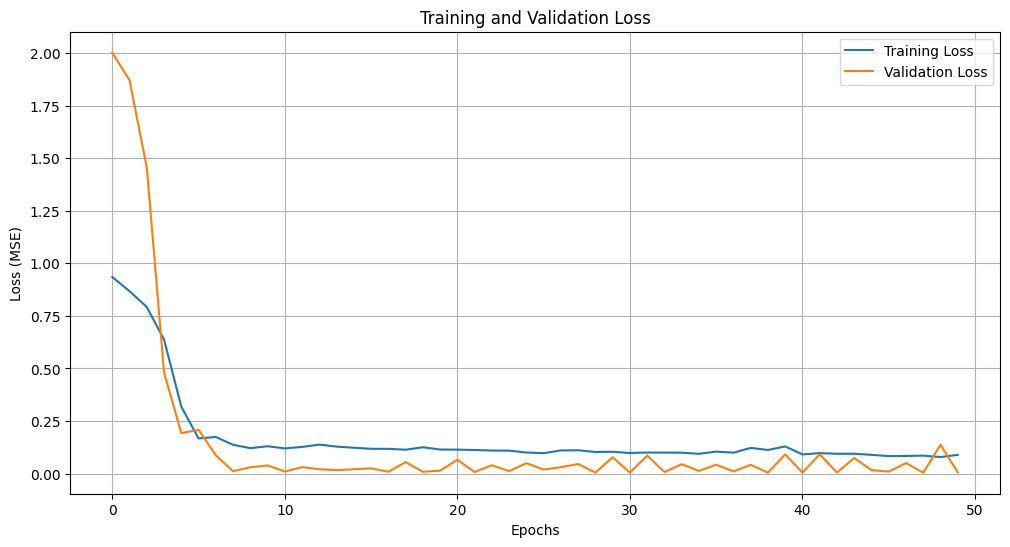

In [833]:
EPOCHS = 50

train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in tqdm(range(EPOCHS)):
    model_1.train()
    train_loss = 0
    
    for batch_X, batch_y in train_loader:
        outputs = model_1(batch_X)
        loss = criterion(outputs, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)
    
    model_1.eval()
    val_loss = 0
    all_predictions = []
    all_actual = []
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            val_outputs = model_1(batch_X)
            batch_loss = criterion(val_outputs, batch_y)
            val_loss += batch_loss.item()
            
            all_predictions.extend(val_outputs.cpu().numpy())
            all_actual.extend(y_batch.cpu().numpy())
        
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
    
    scheduler.step(val_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], '
              f'Train Loss: {train_loss:.6f}, '
              f'Val Loss: {val_loss:.6f}')

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Predictions vs Actual (Original Scale)')

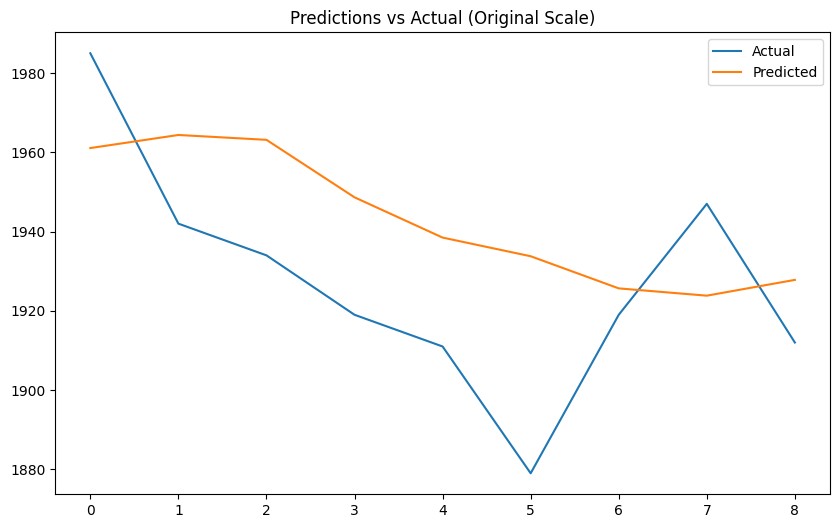

In [834]:
eval_predictions = np.array(all_predictions)
eval_actual = np.array(all_actual)

eval_predictions = scaler_target.inverse_transform(eval_predictions.reshape(-1, 1))
eval_actual = scaler_target.inverse_transform(eval_actual.reshape(-1, 1))

eval_predictions = np.expm1(eval_predictions)
eval_actual = np.expm1(eval_actual)

plt.figure(figsize=(10, 6))
plt.plot(eval_actual, label='Actual')
plt.plot(eval_predictions, label='Predicted')
plt.legend()
plt.title('Predictions vs Actual (Original Scale)')

In [835]:
# MSE
mse = mean_squared_error(eval_actual, eval_predictions)
print(f"Mean Squared Error: {mse:.2f}")
# RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse:.2f}")
# MAE
mae = mean_absolute_error(eval_actual, eval_predictions)
print(f"Mean Absolute Error: {mae:.2f}")
# MAPE
mape = np.mean(np.abs((eval_actual - eval_predictions) / eval_actual)) * 100
print(f"Mean Absolute Percentage Error: {mape:.2f}%")

Mean Squared Error: 821.03
Root Mean Squared Error: 28.65
Mean Absolute Error: 25.89
Mean Absolute Percentage Error: 1.35%
